# Projet Leyenda - Livrable 1 - Classification binaire

## Sommaire

* [1. Introduction](#chapiter1)
    * [1.1. Rappel du besoin](#section_1_1)
    * [1.2. Expression du besoin](#section_1_2)
    * [1.3. Contraintes](#section_1_3)
* [2. Réalisation du modèle de classification](#chapter2)
    * [2.1. Import des librairies Python](#section_2_1) 
* [3. Analyse des résultats](#chapiter3)
* [4. Amélioration du modèle](#chapiter4)
* [5. Conclusion](#chapitre5)

## 1. Introduction <a class="anchor" id="chapter1"></a>

### 1.1 Rappel du besoin <a class="anchor" id="section_1_1"></a>

<div style="text-align: justify">Dans le cadre de ce projet l'entreprise TouNum spécialisée dans la numérisation de documents souhaite étendre leur gamme de services pour inclure des outils de Machine Learning. En effet, leur clientèle possédant une grande quantité de données à numériser au format papier. Dans le but de rester compétitif dans ce secteur d’activité l’entreprise décide d’innover et proposer un service de catégorisation qui serait plus que valorisable. Afin de mener à bien cette tâche, des spécialistes en Data Science de CESI ont été contactés.
<p>

L’objectif de cette première partie est d’automatiser la sélection des photos pour l’annotation. Pour ce faire, nous nous basons sur les réseaux de neurones afin de filtrer les images qui ne sont pas des photos dans le dataset de départ.<div>

### 1.2 Expression du besoin <a class="anchor" id="section_1_2"></a>

<div style="text-align: justify">Afin d’apporter une réponse adaptée à la problématique énoncée dans l’introduction de ce notebook. Il nous apparaît intéressant d’analyser le besoin de l’utilisateur final. Cette démarche a pour but de 
donner un point de vue global des attendus aux quelles la solution doit répondre. Ce qui nous 
donnera une ligne directrice à suivre tout au long de ce notebook. Afin, de donner un aperçu plus clair sur la marche à suivre pour répondre au besoin exprimé nous pouvons nous aider du diagramme bête à corne ci dessous.</div>

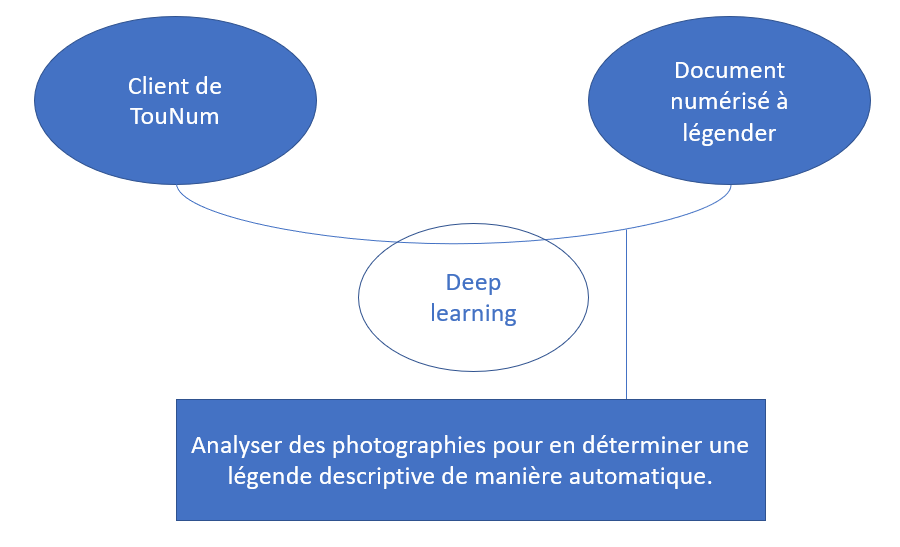
<center><em>Diagrame Bete à corne</em></center>

### 1.3 Contraintes <a class="anchor" id="section_1_3"></a>

<div style="text-align: justify">Cette première partie comporte plusieurs contraintes liées à la vision par ordinateur. En effet, nous devons être en capacité de déterminer si les images sont des photos sans tenir compte de l’orientation, de la luminosité, ou la  variation d’échelle de celles-ci. De plus, nous devrons extraire les features qui nous permettrons de distinguer les différences entre les types d’images qui composent le dataset.</div>  

## 2. Réalisation du modèle de classification <a class="anchor" id="chapter2"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten

In [2]:
import pathlib

data_dir = pathlib.Path("Class")

In [3]:
image_h = 180
image_w = 180
batch_s = 32

In [4]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="training",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s
)

# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="validation",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s
)

Found 41405 files belonging to 2 classes.
Using 33124 files for training.
Found 41405 files belonging to 2 classes.
Using 8281 files for validation.


In [5]:
class_names = train_set.class_names
print(class_names)

['Autre', 'Photo']


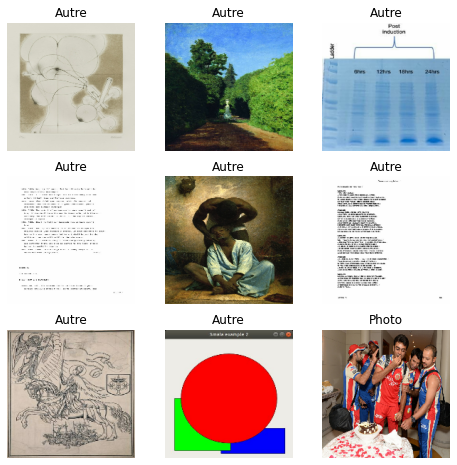

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

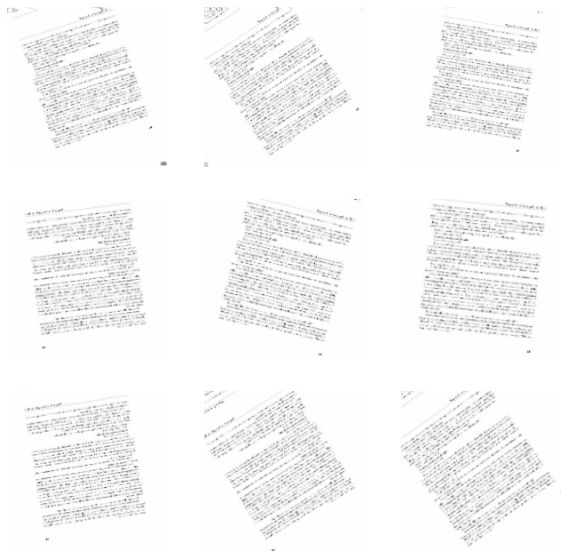

In [9]:
#Fonction s'occupant de la data augmentation, aujoutant au dataset d'entrainement des images légèrements modifiées par leur orientation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(image_h, 
                                                              image_w,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_set.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Rajoutez ensuite l'augmentation des données à votre CNN et vérifiez les courbes obtenues après entrainement et évaluation du modèle.

### Keras Tuner

In [10]:
#Déinition du modèle avec HyperParametre en paramètre
def model_builder(hp):
    # Le modèle
    complete_model = Sequential([
      data_augmentation,
      layers.experimental.preprocessing.Rescaling(1./255),
    #Ajout d'une première couche de convolution
      layers.Conv2D(
          #ajout de filtres
          filters=hp.Int('conv_1_filter', min_value=16, max_value=128, step=16),
          kernel_size=hp.Choice('conv_1_kernel', values = [3,5]), 
          padding='same', 
          activation='relu'),
      layers.MaxPooling2D(),
    #Ajout d'une deuxième couche de convolution
      layers.Conv2D(
          filters=hp.Int('conv_2_filter', min_value=16, max_value=128, step=16), 
          kernel_size=hp.Choice('conv_2_kernel', values = [3,5]), 
          padding='same', 
          activation='relu'),
      layers.MaxPooling2D(),
    #Ajout d'une troisième couche de convolution 
      layers.Conv2D(
          filters=hp.Int('conv_3_filter', min_value=16, max_value=128, step=16), 
          kernel_size=hp.Choice('conv_3_kernel', values = [3,5]), 
          padding='same', 
          activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(
          units=hp.Int('dense_1_units', min_value=16, max_value=128, step=16), 
          activation='relu'),
      layers.Dense(1, activation='sigmoid')
    ])
    # Compilation du modèle
    complete_model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])
    # Résumé du modèle
    complete_model.summary()

    return complete_model

In [11]:
#importing random search
from keras_tuner import RandomSearch
#creating randomsearch object
tuner = RandomSearch(model_builder,
                    objective='val_accuracy',
                    max_trials = 5)
# search best parameter
# tuple((images, labels) for x in train_set)
with tf.device('/device:GPU:0'):
    tuner.search(train_set,epochs=20,validation_data=test_set, callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 16)        0         
____________________________________

In [12]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv_1_filter: 32
conv_1_kernel: 5
conv_2_filter: 48
conv_2_kernel: 5
conv_3_filter: 32
conv_3_kernel: 3
dense_1_units: 80
learning_rate: 0.001
Score: 0.9082236289978027
Trial summary
Hyperparameters:
conv_1_filter: 64
conv_1_kernel: 5
conv_2_filter: 48
conv_2_kernel: 3
conv_3_filter: 32
conv_3_kernel: 3
dense_1_units: 80
learning_rate: 0.001
Score: 0.8911967277526855
Trial summary
Hyperparameters:
conv_1_filter: 80
conv_1_kernel: 5
conv_2_filter: 16
conv_2_kernel: 3
conv_3_filter: 32
conv_3_kernel: 5
dense_1_units: 48
learning_rate: 0.01
Score: 0.7906050086021423
Trial summary
Hyperparameters:
conv_1_filter: 80
conv_1_kernel: 3
conv_2_filter: 16
conv_2_kernel: 5
conv_3_filter: 32
conv_3_kernel: 5
dense_1_units: 16
learning_rate: 0.01
Score: 0.765608012676239
Trial summary
Hyperparameters:
conv_1_filter: 16
conv_1_kernel: 5
conv_2_filter: 4

In [13]:
complete_model=tuner.get_best_models(num_models=1)[0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 48)        38448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        1

In [ ]:
# Entrainement du modèle
with tf.device('/device:GPU:0'):
    epochs = 10
    history = complete_model.fit(
      train_set,
      validation_data=test_set,
      epochs=epochs)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Epoch 1/10


Nous observons cette fois une nette amélioration des performances, la précision dans le jeu de test atteint une valeur proche de la précision dans le jeu d’entrainement, et la perte du jeu de test baisse de façon quasi continuelle au cours de l’entrainement. Voilà une bonne nouvelle. Que remarquez-vous d'autre ?
<em>À COMPLÉTER</em>


In [ ]:
complete_model.save('saved_model/my_model')


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing import image

# predicting images
image_path = 'oui.jfif'
img = image.load_img(image_path, target_size=(180, 180))
x = image.img_to_array(img)
plt.imshow(x/255.)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = complete_model.predict(images, batch_size=10)
print(classes[0])
if classes[0]<0.5:
  print(image_path + " n'est pas une photo")
else:
  print(image_path + " est une photo")